In [1]:
from bitarray import bitarray
import random
import numpy as np
import math
import timeit

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [4]:
import pandas as pd
import os

In [5]:
from sklearn import datasets

In [6]:
bcancer = datasets.load_breast_cancer()
X = bcancer.data  
y = bcancer.target
X = StandardScaler().fit_transform(X)

In [7]:
x_neg=X[y==0]
x_pos=X[y==1]
y_pos=y[y==1]
y_neg=y[y==0]
np.random.shuffle(x_neg)
print(x_neg.shape)
print(x_pos.shape)

(212, 30)
(357, 30)


In [8]:
indices=np.arange(106)
#x_train=np.array(x_neg[0:106])[indices]
y_train=y_neg[0:106]
x_train=np.concatenate((np.array(x_neg[0:106])[indices],x_pos)).reshape(-1,30)
y_train=np.concatenate((y_train,y_pos)).reshape(-1,1)

In [9]:
x_test = x_neg[106:212].reshape(-1,30)
y_test = y_neg[106:212].reshape(-1,1)

# Projection model

In [10]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1
       # print(vectors)        
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

In [11]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values,times):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        start = timeit.default_timer()
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        stop = timeit.default_timer()
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f - Time Taken to create filter(sec): %f \n\n\n" % (m,fpr_test,stop-start))
        fpr_values += [fpr_test]
        size_values += [m]
        times += [stop-start]

In [12]:
num_of_iterations = 50 #Increase to make graph smoother

fpr_values = []
size_values = []
times = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,10,10,300,100,fpr_values,size_values,times)

~~~~~~~~ Iteration 1 ~~~~~~~~ 

(357, 30)
Size: 10 Bits - FPR: 0.443396 - Time Taken to create filter(sec): 0.160984 



Size: 20 Bits - FPR: 0.462264 - Time Taken to create filter(sec): 0.149614 



Size: 30 Bits - FPR: 0.330189 - Time Taken to create filter(sec): 0.201763 



Size: 40 Bits - FPR: 0.386792 - Time Taken to create filter(sec): 0.166423 



Size: 50 Bits - FPR: 0.443396 - Time Taken to create filter(sec): 0.181681 



Size: 60 Bits - FPR: 0.377358 - Time Taken to create filter(sec): 0.167264 



Size: 70 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.135574 



Size: 80 Bits - FPR: 0.264151 - Time Taken to create filter(sec): 0.121136 



Size: 90 Bits - FPR: 0.273585 - Time Taken to create filter(sec): 0.118667 



Size: 100 Bits - FPR: 0.226415 - Time Taken to create filter(sec): 0.167005 



Size: 110 Bits - FPR: 0.264151 - Time Taken to create filter(sec): 0.173558 



Size: 120 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.160094 



Size: 1

Size: 1030 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.101253 



Size: 1040 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.133410 



Size: 1050 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.130703 



Size: 1060 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.114644 



Size: 1070 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.114596 



Size: 1080 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.117339 



Size: 1090 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.125852 



Size: 1100 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.135352 



Size: 1110 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.117660 



Size: 1120 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.119208 



Size: 1130 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.136364 



Size: 1140 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.138997 



Size: 1150 Bits - FPR: 0.075

Size: 2050 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.276508 



Size: 2060 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.375734 



Size: 2070 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.456196 



Size: 2080 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.290534 



Size: 2090 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.717241 



Size: 2100 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.291629 



Size: 2110 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.235421 



Size: 2120 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.231702 



Size: 2130 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.227841 



Size: 2140 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.197511 



Size: 2150 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.214451 



Size: 2160 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.250387 



Size: 2170 Bits - FPR: 0.066

Size: 60 Bits - FPR: 0.386792 - Time Taken to create filter(sec): 0.111691 



Size: 70 Bits - FPR: 0.452830 - Time Taken to create filter(sec): 0.099548 



Size: 80 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.097843 



Size: 90 Bits - FPR: 0.226415 - Time Taken to create filter(sec): 0.100279 



Size: 100 Bits - FPR: 0.320755 - Time Taken to create filter(sec): 0.108060 



Size: 110 Bits - FPR: 0.235849 - Time Taken to create filter(sec): 0.114755 



Size: 120 Bits - FPR: 0.254717 - Time Taken to create filter(sec): 0.100511 



Size: 130 Bits - FPR: 0.292453 - Time Taken to create filter(sec): 0.097602 



Size: 140 Bits - FPR: 0.245283 - Time Taken to create filter(sec): 0.116260 



Size: 150 Bits - FPR: 0.273585 - Time Taken to create filter(sec): 0.096712 



Size: 160 Bits - FPR: 0.264151 - Time Taken to create filter(sec): 0.124269 



Size: 170 Bits - FPR: 0.292453 - Time Taken to create filter(sec): 0.098100 



Size: 180 Bits - FPR: 0.132075 - Time Taken 

Size: 1100 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.215649 



Size: 1110 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.244635 



Size: 1120 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.139025 



Size: 1130 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.165999 



Size: 1140 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.192886 



Size: 1150 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.203008 



Size: 1160 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.305494 



Size: 1170 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.345156 



Size: 1180 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.130811 



Size: 1190 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.131795 



Size: 1200 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.217637 



Size: 1210 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.125655 



Size: 1220 Bits - FPR: 0.066

Size: 2120 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.224178 



Size: 2130 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.194057 



Size: 2140 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.163259 



Size: 2150 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.151161 



Size: 2160 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.150615 



Size: 2170 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.153299 



Size: 2180 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.170884 



Size: 2190 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.181584 



Size: 2200 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.158515 



Size: 2210 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.179221 



Size: 2220 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.155560 



Size: 2230 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.154680 



Size: 2240 Bits - FPR: 0.056

Size: 130 Bits - FPR: 0.198113 - Time Taken to create filter(sec): 0.114760 



Size: 140 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.098016 



Size: 150 Bits - FPR: 0.273585 - Time Taken to create filter(sec): 0.100151 



Size: 160 Bits - FPR: 0.339623 - Time Taken to create filter(sec): 0.104951 



Size: 170 Bits - FPR: 0.235849 - Time Taken to create filter(sec): 0.098358 



Size: 180 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.113437 



Size: 190 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.100127 



Size: 200 Bits - FPR: 0.207547 - Time Taken to create filter(sec): 0.103390 



Size: 210 Bits - FPR: 0.207547 - Time Taken to create filter(sec): 0.108077 



Size: 220 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.097513 



Size: 230 Bits - FPR: 0.254717 - Time Taken to create filter(sec): 0.104959 



Size: 240 Bits - FPR: 0.188679 - Time Taken to create filter(sec): 0.099557 



Size: 250 Bits - FPR: 0.094340 - Time Ta

Size: 1170 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.113859 



Size: 1180 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.114407 



Size: 1190 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.113720 



Size: 1200 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.112410 



Size: 1210 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.117309 



Size: 1220 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.115993 



Size: 1230 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.114837 



Size: 1240 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.112367 



Size: 1250 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.121649 



Size: 1260 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.112521 



Size: 1270 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.121641 



Size: 1280 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.115239 



Size: 1290 Bits - FPR: 0.037

Size: 2190 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.152325 



Size: 2200 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.152202 



Size: 2210 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.155855 



Size: 2220 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.148872 



Size: 2230 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.151693 



Size: 2240 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.152641 



Size: 2250 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.150030 



Size: 2260 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.149911 



Size: 2270 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.169972 



Size: 2280 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.190530 



Size: 2290 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.150028 



Size: 2300 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.150894 



Size: 2310 Bits - FPR: 0.056

Size: 210 Bits - FPR: 0.358491 - Time Taken to create filter(sec): 0.098602 



Size: 220 Bits - FPR: 0.235849 - Time Taken to create filter(sec): 0.110038 



Size: 230 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.148431 



Size: 240 Bits - FPR: 0.207547 - Time Taken to create filter(sec): 0.144164 



Size: 250 Bits - FPR: 0.169811 - Time Taken to create filter(sec): 0.126022 



Size: 260 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.119422 



Size: 270 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.214118 



Size: 280 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.130634 



Size: 290 Bits - FPR: 0.169811 - Time Taken to create filter(sec): 0.108468 



Size: 300 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.098773 



Size: 310 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.099176 



Size: 320 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.125884 



Size: 330 Bits - FPR: 0.150943 - Time Ta

Size: 1240 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.161813 



Size: 1250 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.167937 



Size: 1260 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.171162 



Size: 1270 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.156841 



Size: 1280 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.181776 



Size: 1290 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.159183 



Size: 1300 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.167055 



Size: 1310 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.165447 



Size: 1320 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.169841 



Size: 1330 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.155082 



Size: 1340 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.175423 



Size: 1350 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.188591 



Size: 1360 Bits - FPR: 0.047

Size: 2270 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.185816 



Size: 2280 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.151234 



Size: 2290 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.155106 



Size: 2300 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.149624 



Size: 2310 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.179730 



Size: 2320 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.182253 



Size: 2330 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.194121 



Size: 2340 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.183614 



Size: 2350 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.192480 



Size: 2360 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.174106 



Size: 2370 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.161899 



Size: 2380 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.152528 



Size: 2390 Bits - FPR: 0.094

Size: 310 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.107382 



Size: 320 Bits - FPR: 0.198113 - Time Taken to create filter(sec): 0.098307 



Size: 330 Bits - FPR: 0.226415 - Time Taken to create filter(sec): 0.097166 



Size: 340 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.105749 



Size: 350 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.095917 



Size: 360 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.095383 



Size: 370 Bits - FPR: 0.245283 - Time Taken to create filter(sec): 0.105170 



Size: 380 Bits - FPR: 0.254717 - Time Taken to create filter(sec): 0.095642 



Size: 390 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.096209 



Size: 400 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.104211 



Size: 410 Bits - FPR: 0.169811 - Time Taken to create filter(sec): 0.096225 



Size: 420 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.098295 



Size: 430 Bits - FPR: 0.103774 - Time Ta

Size: 1330 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.117882 



Size: 1340 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.113207 



Size: 1350 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.118139 



Size: 1360 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.111819 



Size: 1370 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.117251 



Size: 1380 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.112641 



Size: 1390 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.117082 



Size: 1400 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.113179 



Size: 1410 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.117174 



Size: 1420 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.113180 



Size: 1430 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.117114 



Size: 1440 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.113618 



Size: 1450 Bits - FPR: 0.075

Size: 2350 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.162518 



Size: 2360 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.155090 



Size: 2370 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.155227 



Size: 2380 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.148607 



Size: 2390 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.159298 



Size: 2400 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.150898 



Size: 2410 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.163622 



Size: 2420 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.158705 



Size: 2430 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.162800 



Size: 2440 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.167533 



Size: 2450 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.198018 



Size: 2460 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.203832 



Size: 2470 Bits - FPR: 0.028

Size: 390 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.107586 



Size: 400 Bits - FPR: 0.198113 - Time Taken to create filter(sec): 0.097014 



Size: 410 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.095884 



Size: 420 Bits - FPR: 0.207547 - Time Taken to create filter(sec): 0.106854 



Size: 430 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.096798 



Size: 440 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.099873 



Size: 450 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.105891 



Size: 460 Bits - FPR: 0.226415 - Time Taken to create filter(sec): 0.095778 



Size: 470 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.096475 



Size: 480 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.104983 



Size: 490 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.095856 



Size: 500 Bits - FPR: 0.245283 - Time Taken to create filter(sec): 0.095896 



Size: 510 Bits - FPR: 0.122642 - Time Ta

Size: 1420 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.117243 



Size: 1430 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.113596 



Size: 1440 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.119139 



Size: 1450 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.112872 



Size: 1460 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.117210 



Size: 1470 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.113566 



Size: 1480 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.118051 



Size: 1490 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.112266 



Size: 1500 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.117025 



Size: 1510 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.112174 



Size: 1520 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.116638 



Size: 1530 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.113461 



Size: 1540 Bits - FPR: 0.028

Size: 2440 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.155955 



Size: 2450 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.149513 



Size: 2460 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.154571 



Size: 2470 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.148505 



Size: 2480 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.154611 



Size: 2490 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.149155 



Size: 2500 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.153788 



Size: 2510 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.149487 



Size: 2520 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.154625 



Size: 2530 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.147792 



Size: 2540 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.154193 



Size: 2550 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.173654 



Size: 2560 Bits - FPR: 0.018

Size: 460 Bits - FPR: 0.169811 - Time Taken to create filter(sec): 0.107522 



Size: 470 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.097190 



Size: 480 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.095817 



Size: 490 Bits - FPR: 0.245283 - Time Taken to create filter(sec): 0.106457 



Size: 500 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.095362 



Size: 510 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.095343 



Size: 520 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.105208 



Size: 530 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.098635 



Size: 540 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.097744 



Size: 550 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.107843 



Size: 560 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.097105 



Size: 570 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.096303 



Size: 580 Bits - FPR: 0.084906 - Time Ta

Size: 1480 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.118364 



Size: 1490 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.112138 



Size: 1500 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.118207 



Size: 1510 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.113444 



Size: 1520 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.117185 



Size: 1530 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.113308 



Size: 1540 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.117165 



Size: 1550 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.132711 



Size: 1560 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.137159 



Size: 1570 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.131507 



Size: 1580 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.137682 



Size: 1590 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.131094 



Size: 1600 Bits - FPR: 0.094

Size: 2500 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.159818 



Size: 2510 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.149421 



Size: 2520 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.154478 



Size: 2530 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.149282 



Size: 2540 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.155292 



Size: 2550 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.149361 



Size: 2560 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.154713 



Size: 2570 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.148702 



Size: 2580 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.174495 



Size: 2590 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.169387 



Size: 2600 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.173673 



Size: 2610 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.167568 



Size: 2620 Bits - FPR: 0.066

Size: 530 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.115602 



Size: 540 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.100385 



Size: 550 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.101125 



Size: 560 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.106314 



Size: 570 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.098709 



Size: 580 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.096763 



Size: 590 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.106165 



Size: 600 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.097717 



Size: 610 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.104726 



Size: 620 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.106131 



Size: 630 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.097557 



Size: 640 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.097184 



Size: 650 Bits - FPR: 0.075472 - Time Ta

Size: 1560 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.137336 



Size: 1570 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.132256 



Size: 1580 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.137238 



Size: 1590 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.130916 



Size: 1600 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.137597 



Size: 1610 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.130633 



Size: 1620 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.137740 



Size: 1630 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.136079 



Size: 1640 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.137324 



Size: 1650 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.131293 



Size: 1660 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.137857 



Size: 1670 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.131267 



Size: 1680 Bits - FPR: 0.037

Size: 2580 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.176045 



Size: 2590 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.172651 



Size: 2600 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.174671 



Size: 2610 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.169155 



Size: 2620 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.175103 



Size: 2630 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.173771 



Size: 2640 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.174729 



Size: 2650 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.174028 



Size: 2660 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.176531 



Size: 2670 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.171904 



Size: 2680 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.183199 



Size: 2690 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.182746 



Size: 2700 Bits - FPR: 0.028

Size: 600 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.109149 



Size: 610 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.099132 



Size: 620 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.096298 



Size: 630 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.109697 



Size: 640 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.097350 



Size: 650 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.098066 



Size: 660 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.104358 



Size: 670 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.096020 



Size: 680 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.095740 



Size: 690 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.105957 



Size: 700 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.096050 



Size: 710 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.097147 



Size: 720 Bits - FPR: 0.084906 - Time Ta

Size: 1620 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.138281 



Size: 1630 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.131171 



Size: 1640 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.137753 



Size: 1650 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.131028 



Size: 1660 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.139662 



Size: 1670 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.134330 



Size: 1680 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.141664 



Size: 1690 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.135917 



Size: 1700 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.152912 



Size: 1710 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.141341 



Size: 1720 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.163987 



Size: 1730 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.141480 



Size: 1740 Bits - FPR: 0.018

Size: 2640 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.173615 



Size: 2650 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.173265 



Size: 2660 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.178697 



Size: 2670 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.169495 



Size: 2680 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.196594 



Size: 2690 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.169913 



Size: 2700 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.174707 



Size: 2710 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.169732 



Size: 2720 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.173132 



Size: 2730 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.170432 



Size: 2740 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.174266 



Size: 2750 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.169480 



Size: 2760 Bits - FPR: 0.018

Size: 670 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.153730 



Size: 680 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.182500 



Size: 690 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.108843 



Size: 700 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.097569 



Size: 710 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.108609 



Size: 720 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.107298 



Size: 730 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.097822 



Size: 740 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.108216 



Size: 750 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.096422 



Size: 760 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.115926 



Size: 770 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.184717 



Size: 780 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.243343 



Size: 790 Bits - FPR: 0.160377 - Time Ta

Size: 1690 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.139891 



Size: 1700 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.131306 



Size: 1710 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.139219 



Size: 1720 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.130925 



Size: 1730 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.137104 



Size: 1740 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.132305 



Size: 1750 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.137834 



Size: 1760 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.131033 



Size: 1770 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.138010 



Size: 1780 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.133703 



Size: 1790 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.146070 



Size: 1800 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.160280 



Size: 1810 Bits - FPR: 0.000

Size: 2710 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.176211 



Size: 2720 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.169952 



Size: 2730 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.175377 



Size: 2740 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.169503 



Size: 2750 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.173372 



Size: 2760 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.171802 



Size: 2770 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.174509 



Size: 2780 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.170146 



Size: 2790 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.174168 



Size: 2800 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.171925 



Size: 2810 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.183576 



Size: 2820 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.181371 



Size: 2830 Bits - FPR: 0.028

Size: 730 Bits - FPR: 0.207547 - Time Taken to create filter(sec): 0.106511 



Size: 740 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.095390 



Size: 750 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.095757 



Size: 760 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.106712 



Size: 770 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.096750 



Size: 780 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.095697 



Size: 790 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.108446 



Size: 800 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.095778 



Size: 810 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.097432 



Size: 820 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.105149 



Size: 830 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.096170 



Size: 840 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.095324 



Size: 850 Bits - FPR: 0.132075 - Time Ta

Size: 1750 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.138626 



Size: 1760 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.131222 



Size: 1770 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.136892 



Size: 1780 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.131041 



Size: 1790 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.136650 



Size: 1800 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.131709 



Size: 1810 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.136049 



Size: 1820 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.130998 



Size: 1830 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.136959 



Size: 1840 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.130274 



Size: 1850 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.136704 



Size: 1860 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.130768 



Size: 1870 Bits - FPR: 0.047

Size: 2770 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.174289 



Size: 2780 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.167052 



Size: 2790 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.172984 



Size: 2800 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.168027 



Size: 2810 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.175066 



Size: 2820 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.167247 



Size: 2830 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.173316 



Size: 2840 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.166485 



Size: 2850 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.173469 



Size: 2860 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.167276 



Size: 2870 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.172725 



Size: 2880 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.166899 



Size: 2890 Bits - FPR: 0.018

Size: 800 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.107578 



Size: 810 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.095938 



Size: 820 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.096559 



Size: 830 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.106033 



Size: 840 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.096495 



Size: 850 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.096144 



Size: 860 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.107192 



Size: 870 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.095426 



Size: 880 Bits - FPR: 0.169811 - Time Taken to create filter(sec): 0.094453 



Size: 890 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.106727 



Size: 900 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.095550 



Size: 910 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.095748 



Size: 920 Bits - FPR: 0.122642 - Time Ta

Size: 1820 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.161299 



Size: 1830 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.149303 



Size: 1840 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.152554 



Size: 1850 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.130705 



Size: 1860 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.159547 



Size: 1870 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.132469 



Size: 1880 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.137982 



Size: 1890 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.130448 



Size: 1900 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.136727 



Size: 1910 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.132216 



Size: 1920 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.141813 



Size: 1930 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.132582 



Size: 1940 Bits - FPR: 0.075

Size: 2850 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.207058 



Size: 2860 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.181833 



Size: 2870 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.173442 



Size: 2880 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.167173 



Size: 2890 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.172857 



Size: 2900 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.167277 



Size: 2910 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.173003 



Size: 2920 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.167327 



Size: 2930 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.172127 



Size: 2940 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.168545 



Size: 2950 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.173343 



Size: 2960 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.170050 



Size: 2970 Bits - FPR: 0.047

Size: 870 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.108770 



Size: 880 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.095707 



Size: 890 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.095345 



Size: 900 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.106418 



Size: 910 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.096162 



Size: 920 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.098874 



Size: 930 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.105123 



Size: 940 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.096403 



Size: 950 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.095862 



Size: 960 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.106532 



Size: 970 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.096809 



Size: 980 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.096387 



Size: 990 Bits - FPR: 0.066038 - Time Ta

Size: 1900 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.145761 



Size: 1910 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.130488 



Size: 1920 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.136741 



Size: 1930 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.133388 



Size: 1940 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.142226 



Size: 1950 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.133196 



Size: 1960 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.139163 



Size: 1970 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.137875 



Size: 1980 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.138667 



Size: 1990 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.135868 



Size: 2000 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.136924 



Size: 2010 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.131119 



Size: 2020 Bits - FPR: 0.047

Size: 2920 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.175889 



Size: 2930 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.167776 



Size: 2940 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.175904 



Size: 2950 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.167758 



Size: 2960 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.174896 



Size: 2970 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.168809 



Size: 2980 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.172983 



Size: 2990 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.172017 



Size: 3000 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.174678 



~~~~~~~~ Iteration 14 ~~~~~~~~ 

(357, 30)
Size: 10 Bits - FPR: 0.415094 - Time Taken to create filter(sec): 0.097543 



Size: 20 Bits - FPR: 0.452830 - Time Taken to create filter(sec): 0.096435 



Size: 30 Bits - FPR: 0.433962 - Time Taken to create filter(sec): 0.10

Size: 950 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.107935 



Size: 960 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.096120 



Size: 970 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.096582 



Size: 980 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.105973 



Size: 990 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.096144 



Size: 1000 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.096658 



Size: 1010 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.106279 



Size: 1020 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.095928 



Size: 1030 Bits - FPR: 0.169811 - Time Taken to create filter(sec): 0.095991 



Size: 1040 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.175844 



Size: 1050 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.126977 



Size: 1060 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.138872 



Size: 1070 Bits - FPR: 0.113208 -

Size: 1980 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.139249 



Size: 1990 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.132734 



Size: 2000 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.137681 



Size: 2010 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.131611 



Size: 2020 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.137220 



Size: 2030 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.130915 



Size: 2040 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.136929 



Size: 2050 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.131350 



Size: 2060 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.137552 



Size: 2070 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.149454 



Size: 2080 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.156729 



Size: 2090 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.149183 



Size: 2100 Bits - FPR: 0.132

Size: 3000 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.221554 



~~~~~~~~ Iteration 15 ~~~~~~~~ 

(357, 30)
Size: 10 Bits - FPR: 0.358491 - Time Taken to create filter(sec): 0.157206 



Size: 20 Bits - FPR: 0.226415 - Time Taken to create filter(sec): 0.112130 



Size: 30 Bits - FPR: 0.443396 - Time Taken to create filter(sec): 0.098949 



Size: 40 Bits - FPR: 0.339623 - Time Taken to create filter(sec): 0.097610 



Size: 50 Bits - FPR: 0.367925 - Time Taken to create filter(sec): 0.108617 



Size: 60 Bits - FPR: 0.367925 - Time Taken to create filter(sec): 0.106700 



Size: 70 Bits - FPR: 0.226415 - Time Taken to create filter(sec): 0.160672 



Size: 80 Bits - FPR: 0.396226 - Time Taken to create filter(sec): 0.156670 



Size: 90 Bits - FPR: 0.235849 - Time Taken to create filter(sec): 0.152839 



Size: 100 Bits - FPR: 0.264151 - Time Taken to create filter(sec): 0.158016 



Size: 110 Bits - FPR: 0.198113 - Time Taken to create filter(sec): 0.151299 



Size:

Size: 1020 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.155598 



Size: 1030 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.142564 



Size: 1040 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.179346 



Size: 1050 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.124818 



Size: 1060 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.140583 



Size: 1070 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.113556 



Size: 1080 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.117536 



Size: 1090 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.114839 



Size: 1100 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.120609 



Size: 1110 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.113239 



Size: 1120 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.117747 



Size: 1130 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.113981 



Size: 1140 Bits - FPR: 0.075

Size: 2040 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.136848 



Size: 2050 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.130576 



Size: 2060 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.136700 



Size: 2070 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.149044 



Size: 2080 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.155257 



Size: 2090 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.149066 



Size: 2100 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.154802 



Size: 2110 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.149108 



Size: 2120 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.154611 



Size: 2130 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.148789 



Size: 2140 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.155168 



Size: 2150 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.149267 



Size: 2160 Bits - FPR: 0.037

Size: 70 Bits - FPR: 0.254717 - Time Taken to create filter(sec): 0.108422 



Size: 80 Bits - FPR: 0.198113 - Time Taken to create filter(sec): 0.098667 



Size: 90 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.096987 



Size: 100 Bits - FPR: 0.264151 - Time Taken to create filter(sec): 0.106989 



Size: 110 Bits - FPR: 0.254717 - Time Taken to create filter(sec): 0.097607 



Size: 120 Bits - FPR: 0.264151 - Time Taken to create filter(sec): 0.097473 



Size: 130 Bits - FPR: 0.264151 - Time Taken to create filter(sec): 0.107751 



Size: 140 Bits - FPR: 0.339623 - Time Taken to create filter(sec): 0.096295 



Size: 150 Bits - FPR: 0.245283 - Time Taken to create filter(sec): 0.096848 



Size: 160 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.106580 



Size: 170 Bits - FPR: 0.198113 - Time Taken to create filter(sec): 0.096331 



Size: 180 Bits - FPR: 0.207547 - Time Taken to create filter(sec): 0.097506 



Size: 190 Bits - FPR: 0.273585 - Time Taken

Size: 1110 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.122702 



Size: 1120 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.114434 



Size: 1130 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.119364 



Size: 1140 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.117574 



Size: 1150 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.120169 



Size: 1160 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.117423 



Size: 1170 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.126668 



Size: 1180 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.118742 



Size: 1190 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.123122 



Size: 1200 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.112511 



Size: 1210 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.117499 



Size: 1220 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.113350 



Size: 1230 Bits - FPR: 0.075

Size: 2130 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.208518 



Size: 2140 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.195792 



Size: 2150 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.206219 



Size: 2160 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.192792 



Size: 2170 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.194812 



Size: 2180 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.159004 



Size: 2190 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.156003 



Size: 2200 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.149744 



Size: 2210 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.174825 



Size: 2220 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.211510 



Size: 2230 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.207155 



Size: 2240 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.226370 



Size: 2250 Bits - FPR: 0.056

Size: 140 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.114764 



Size: 150 Bits - FPR: 0.207547 - Time Taken to create filter(sec): 0.106043 



Size: 160 Bits - FPR: 0.245283 - Time Taken to create filter(sec): 0.107794 



Size: 170 Bits - FPR: 0.273585 - Time Taken to create filter(sec): 0.107817 



Size: 180 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.109299 



Size: 190 Bits - FPR: 0.188679 - Time Taken to create filter(sec): 0.111677 



Size: 200 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.109040 



Size: 210 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.105746 



Size: 220 Bits - FPR: 0.273585 - Time Taken to create filter(sec): 0.108572 



Size: 230 Bits - FPR: 0.188679 - Time Taken to create filter(sec): 0.114430 



Size: 240 Bits - FPR: 0.207547 - Time Taken to create filter(sec): 0.109001 



Size: 250 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.108684 



Size: 260 Bits - FPR: 0.216981 - Time Ta

Size: 1170 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.134777 



Size: 1180 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.137739 



Size: 1190 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.134621 



Size: 1200 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.140674 



Size: 1210 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.233871 



Size: 1220 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.238241 



Size: 1230 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.233090 



Size: 1240 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.182163 



Size: 1250 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.162942 



Size: 1260 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.160622 



Size: 1270 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.130151 



Size: 1280 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.114158 



Size: 1290 Bits - FPR: 0.094

Size: 2190 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.149700 



Size: 2200 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.149431 



Size: 2210 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.150121 



Size: 2220 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.148766 



Size: 2230 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.150192 



Size: 2240 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.147792 



Size: 2250 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.149684 



Size: 2260 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.148504 



Size: 2270 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.150295 



Size: 2280 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.149176 



Size: 2290 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.149797 



Size: 2300 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.148447 



Size: 2310 Bits - FPR: 0.018

Size: 200 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.130082 



Size: 210 Bits - FPR: 0.169811 - Time Taken to create filter(sec): 0.123420 



Size: 220 Bits - FPR: 0.207547 - Time Taken to create filter(sec): 0.129115 



Size: 230 Bits - FPR: 0.273585 - Time Taken to create filter(sec): 0.105334 



Size: 240 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.128619 



Size: 250 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.097038 



Size: 260 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.096388 



Size: 270 Bits - FPR: 0.198113 - Time Taken to create filter(sec): 0.100042 



Size: 280 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.116861 



Size: 290 Bits - FPR: 0.169811 - Time Taken to create filter(sec): 0.104671 



Size: 300 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.096359 



Size: 310 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.095910 



Size: 320 Bits - FPR: 0.179245 - Time Ta

Size: 1230 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.114419 



Size: 1240 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.112906 



Size: 1250 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.117880 



Size: 1260 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.115461 



Size: 1270 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.114475 



Size: 1280 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.112307 



Size: 1290 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.123951 



Size: 1300 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.114880 



Size: 1310 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.114595 



Size: 1320 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.112526 



Size: 1330 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.116051 



Size: 1340 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.116427 



Size: 1350 Bits - FPR: 0.103

Size: 2250 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.166824 



Size: 2260 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.171909 



Size: 2270 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.212241 



Size: 2280 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.211139 



Size: 2290 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.189435 



Size: 2300 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.163009 



Size: 2310 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.224912 



Size: 2320 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.164931 



Size: 2330 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.151515 



Size: 2340 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.154507 



Size: 2350 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.184075 



Size: 2360 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.186955 



Size: 2370 Bits - FPR: 0.028

Size: 270 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.154420 



Size: 280 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.103291 



Size: 290 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.097743 



Size: 300 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.100426 



Size: 310 Bits - FPR: 0.207547 - Time Taken to create filter(sec): 0.096411 



Size: 320 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.104182 



Size: 330 Bits - FPR: 0.226415 - Time Taken to create filter(sec): 0.150066 



Size: 340 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.131680 



Size: 350 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.143034 



Size: 360 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.157594 



Size: 370 Bits - FPR: 0.301887 - Time Taken to create filter(sec): 0.170862 



Size: 380 Bits - FPR: 0.188679 - Time Taken to create filter(sec): 0.131776 



Size: 390 Bits - FPR: 0.169811 - Time Ta


Size: 1300 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.192900 



Size: 1310 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.143149 



Size: 1320 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.194313 



Size: 1330 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.142651 



Size: 1340 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.113985 



Size: 1350 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.269039 



Size: 1360 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.116632 



Size: 1370 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.114768 



Size: 1380 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.112408 



Size: 1390 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.115743 



Size: 1400 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.112273 



Size: 1410 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.114276 



Size: 1420 Bits - FPR: 0.00

Size: 2320 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.169249 



Size: 2330 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.175140 



Size: 2340 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.160817 



Size: 2350 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.150165 



Size: 2360 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.149842 



Size: 2370 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.150398 



Size: 2380 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.150283 



Size: 2390 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.148912 



Size: 2400 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.150410 



Size: 2410 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.148635 



Size: 2420 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.149746 



Size: 2430 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.148781 



Size: 2440 Bits - FPR: 0.018

Size: 340 Bits - FPR: 0.216981 - Time Taken to create filter(sec): 0.130934 



Size: 350 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.095335 



Size: 360 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.098111 



Size: 370 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.113146 



Size: 380 Bits - FPR: 0.245283 - Time Taken to create filter(sec): 0.096988 



Size: 390 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.103440 



Size: 400 Bits - FPR: 0.169811 - Time Taken to create filter(sec): 0.099374 



Size: 410 Bits - FPR: 0.207547 - Time Taken to create filter(sec): 0.132695 



Size: 420 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.111733 



Size: 430 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.105713 



Size: 440 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.097499 



Size: 450 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.096800 



Size: 460 Bits - FPR: 0.122642 - Time Ta

Size: 1360 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.144084 



Size: 1370 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.124364 



Size: 1380 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.116193 



Size: 1390 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.149603 



Size: 1400 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.114305 



Size: 1410 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.113894 



Size: 1420 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.116474 



Size: 1430 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.146986 



Size: 1440 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.113822 



Size: 1450 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.112279 



Size: 1460 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.115812 



Size: 1470 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.182666 



Size: 1480 Bits - FPR: 0.047

Size: 2390 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.194955 



Size: 2400 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.268960 



Size: 2410 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.229159 



Size: 2420 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.220683 



Size: 2430 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.259347 



Size: 2440 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.258874 



Size: 2450 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.254020 



Size: 2460 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.242623 



Size: 2470 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.250630 



Size: 2480 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.241430 



Size: 2490 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.242056 



Size: 2500 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.192705 



Size: 2510 Bits - FPR: 0.066

Size: 420 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.217988 



Size: 430 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.192040 



Size: 440 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.189596 



Size: 450 Bits - FPR: 0.283019 - Time Taken to create filter(sec): 0.134371 



Size: 460 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.156766 



Size: 470 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.155238 



Size: 480 Bits - FPR: 0.198113 - Time Taken to create filter(sec): 0.156726 



Size: 490 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.212644 



Size: 500 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.197475 



Size: 510 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.223381 



Size: 520 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.355409 



Size: 530 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.180545 



Size: 540 Bits - FPR: 0.084906 - Time Ta

Size: 1440 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.214221 



Size: 1450 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.207460 



Size: 1460 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.140236 



Size: 1470 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.196862 



Size: 1480 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.152577 



Size: 1490 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.139592 



Size: 1500 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.155941 



Size: 1510 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.145274 



Size: 1520 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.141157 



Size: 1530 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.139800 



Size: 1540 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.143042 



Size: 1550 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.169816 



Size: 1560 Bits - FPR: 0.066

Size: 2460 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.190231 



Size: 2470 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.184706 



Size: 2480 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.186313 



Size: 2490 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.186035 



Size: 2500 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.190537 



Size: 2510 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.180217 



Size: 2520 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.189230 



Size: 2530 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.194317 



Size: 2540 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.187589 



Size: 2550 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.188676 



Size: 2560 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.242329 



Size: 2570 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.282613 



Size: 2580 Bits - FPR: 0.018

Size: 480 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.182852 



Size: 490 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.188776 



Size: 500 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.175585 



Size: 510 Bits - FPR: 0.273585 - Time Taken to create filter(sec): 0.184968 



Size: 520 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.183345 



Size: 530 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.182393 



Size: 540 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.188387 



Size: 550 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.176239 



Size: 560 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.166963 



Size: 570 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.192719 



Size: 580 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.175749 



Size: 590 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.186229 



Size: 600 Bits - FPR: 0.122642 - Time Ta

Size: 1510 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.144580 



Size: 1520 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.142601 



Size: 1530 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.146215 



Size: 1540 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.138086 



Size: 1550 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.177543 



Size: 1560 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.164155 



Size: 1570 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.163793 



Size: 1580 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.168829 



Size: 1590 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.165636 



Size: 1600 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.164537 



Size: 1610 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.173368 



Size: 1620 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.162861 



Size: 1630 Bits - FPR: 0.066

Size: 2530 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.186093 



Size: 2540 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.194381 



Size: 2550 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.184134 



Size: 2560 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.191196 



Size: 2570 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.188295 



Size: 2580 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.213539 



Size: 2590 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.218905 



Size: 2600 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.214151 



Size: 2610 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.211209 



Size: 2620 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.206720 



Size: 2630 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.219285 



Size: 2640 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.207021 



Size: 2650 Bits - FPR: 0.018

Size: 550 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.184735 



Size: 560 Bits - FPR: 0.169811 - Time Taken to create filter(sec): 0.184745 



Size: 570 Bits - FPR: 0.188679 - Time Taken to create filter(sec): 0.181274 



Size: 580 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.187384 



Size: 590 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.186518 



Size: 600 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.184881 



Size: 610 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.181001 



Size: 620 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.169696 



Size: 630 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.183391 



Size: 640 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.179751 



Size: 650 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.168231 



Size: 660 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.195432 



Size: 670 Bits - FPR: 0.169811 - Time Ta

Size: 1570 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.149246 



Size: 1580 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.146754 



Size: 1590 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.148544 



Size: 1600 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.153104 



Size: 1610 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.148786 



Size: 1620 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.150096 



Size: 1630 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.154334 



Size: 1640 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.149068 



Size: 1650 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.151544 



Size: 1660 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.148065 



Size: 1670 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.153480 



Size: 1680 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.147678 



Size: 1690 Bits - FPR: 0.037

Size: 2590 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.256477 



Size: 2600 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.190547 



Size: 2610 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.191603 



Size: 2620 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.187652 



Size: 2630 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.186716 



Size: 2640 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.194413 



Size: 2650 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.190906 



Size: 2660 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.184898 



Size: 2670 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.192294 



Size: 2680 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.185875 



Size: 2690 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.191949 



Size: 2700 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.220730 



Size: 2710 Bits - FPR: 0.037

Size: 610 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.250232 



Size: 620 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.198945 



Size: 630 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.170566 



Size: 640 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.179421 



Size: 650 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.174525 



Size: 660 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.170767 



Size: 670 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.177233 



Size: 680 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.180041 



Size: 690 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.169902 



Size: 700 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.178772 



Size: 710 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.174460 



Size: 720 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.179532 



Size: 730 Bits - FPR: 0.094340 - Time Ta

Size: 1630 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.152252 



Size: 1640 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.146485 



Size: 1650 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.148847 



Size: 1660 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.148243 



Size: 1670 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.148980 



Size: 1680 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.148617 



Size: 1690 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.147078 



Size: 1700 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.150512 



Size: 1710 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.149181 



Size: 1720 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.148409 



Size: 1730 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.150699 



Size: 1740 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.146847 



Size: 1750 Bits - FPR: 0.037

Size: 2660 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.192375 



Size: 2670 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.190378 



Size: 2680 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.191863 



Size: 2690 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.188306 



Size: 2700 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.218854 



Size: 2710 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.197583 



Size: 2720 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.258616 



Size: 2730 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.187970 



Size: 2740 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.190641 



Size: 2750 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.188231 



Size: 2760 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.192533 



Size: 2770 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.186101 



Size: 2780 Bits - FPR: 0.009

Size: 690 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.176398 



Size: 700 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.176029 



Size: 710 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.172409 



Size: 720 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.184836 



Size: 730 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.187567 



Size: 740 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.169637 



Size: 750 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.170015 



Size: 760 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.172915 



Size: 770 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.184540 



Size: 780 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.181344 



Size: 790 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.180713 



Size: 800 Bits - FPR: 0.188679 - Time Taken to create filter(sec): 0.175829 



Size: 810 Bits - FPR: 0.084906 - Time Ta

Size: 1710 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.196017 



Size: 1720 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.245758 



Size: 1730 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.147853 



Size: 1740 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.152940 



Size: 1750 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.145436 



Size: 1760 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.153319 



Size: 1770 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.143145 



Size: 1780 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.149306 



Size: 1790 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.149257 



Size: 1800 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.152565 



Size: 1810 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.148663 



Size: 1820 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.151853 



Size: 1830 Bits - FPR: 0.037

Size: 2740 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.191523 



Size: 2750 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.188070 



Size: 2760 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.191674 



Size: 2770 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.188075 



Size: 2780 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.192794 



Size: 2790 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.197265 



Size: 2800 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.189975 



Size: 2810 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.189732 



Size: 2820 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.189428 



Size: 2830 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.190477 



Size: 2840 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.191030 



Size: 2850 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.194724 



Size: 2860 Bits - FPR: 0.037

Size: 760 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.176145 



Size: 770 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.165085 



Size: 780 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.170325 



Size: 790 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.173255 



Size: 800 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.181276 



Size: 810 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.169981 



Size: 820 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.183115 



Size: 830 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.182653 



Size: 840 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.172398 



Size: 850 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.161641 



Size: 860 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.169260 



Size: 870 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.185979 



Size: 880 Bits - FPR: 0.084906 - Time Ta

Size: 1780 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.172691 



Size: 1790 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.223025 



Size: 1800 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.231042 



Size: 1810 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.237842 



Size: 1820 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.171012 



Size: 1830 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.152907 



Size: 1840 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.149315 



Size: 1850 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.150699 



Size: 1860 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.151787 



Size: 1870 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.150001 



Size: 1880 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.149234 



Size: 1890 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.146159 



Size: 1900 Bits - FPR: 0.009

Size: 2800 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.191565 



Size: 2810 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.189588 



Size: 2820 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.190479 



Size: 2830 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.186683 



Size: 2840 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.190878 



Size: 2850 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.189763 



Size: 2860 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.263383 



Size: 2870 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.269429 



Size: 2880 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.293036 



Size: 2890 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.238730 



Size: 2900 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.196453 



Size: 2910 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.198866 



Size: 2920 Bits - FPR: 0.018

Size: 830 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.179196 



Size: 840 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.182103 



Size: 850 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.175418 



Size: 860 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.169578 



Size: 870 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.167814 



Size: 880 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.169016 



Size: 890 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.177627 



Size: 900 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.181988 



Size: 910 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.169651 



Size: 920 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.164983 



Size: 930 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.166474 



Size: 940 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.171250 



Size: 950 Bits - FPR: 0.066038 - Time Ta

Size: 1850 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.149157 



Size: 1860 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.150680 



Size: 1870 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.150450 



Size: 1880 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.147858 



Size: 1890 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.149320 



Size: 1900 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.147574 



Size: 1910 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.147670 



Size: 1920 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.144978 



Size: 1930 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.153820 



Size: 1940 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.146101 



Size: 1950 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.149775 



Size: 1960 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.144105 



Size: 1970 Bits - FPR: 0.028

Size: 2870 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.219419 



Size: 2880 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.310144 



Size: 2890 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.279422 



Size: 2900 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.250275 



Size: 2910 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.205871 



Size: 2920 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.229442 



Size: 2930 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.189400 



Size: 2940 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.189188 



Size: 2950 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.188111 



Size: 2960 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.191154 



Size: 2970 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.185273 



Size: 2980 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.186694 



Size: 2990 Bits - FPR: 0.018

Size: 900 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.181109 



Size: 910 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.195092 



Size: 920 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.176328 



Size: 930 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.180574 



Size: 940 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.172196 



Size: 950 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.152285 



Size: 960 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.152977 



Size: 970 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.164611 



Size: 980 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.179073 



Size: 990 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.180839 



Size: 1000 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.170991 



Size: 1010 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.178180 



Size: 1020 Bits - FPR: 0.028302 - Time

Size: 1920 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.153304 



Size: 1930 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.144766 



Size: 1940 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.147273 



Size: 1950 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.148266 



Size: 1960 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.148763 



Size: 1970 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.147850 



Size: 1980 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.146532 



Size: 1990 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.146758 



Size: 2000 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.148241 



Size: 2010 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.148993 



Size: 2020 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.149520 



Size: 2030 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.145678 



Size: 2040 Bits - FPR: 0.047

Size: 2950 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.192324 



Size: 2960 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.190554 



Size: 2970 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.187398 



Size: 2980 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.187058 



Size: 2990 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.242222 



Size: 3000 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.250856 



~~~~~~~~ Iteration 29 ~~~~~~~~ 

(357, 30)
Size: 10 Bits - FPR: 0.594340 - Time Taken to create filter(sec): 0.170953 



Size: 20 Bits - FPR: 0.471698 - Time Taken to create filter(sec): 0.175436 



Size: 30 Bits - FPR: 0.367925 - Time Taken to create filter(sec): 0.183783 



Size: 40 Bits - FPR: 0.405660 - Time Taken to create filter(sec): 0.186000 



Size: 50 Bits - FPR: 0.358491 - Time Taken to create filter(sec): 0.183155 



Size: 60 Bits - FPR: 0.396226 - Time Taken to create filter(sec): 0.174625 


Size: 970 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.171606 



Size: 980 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.191171 



Size: 990 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.192289 



Size: 1000 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.160639 



Size: 1010 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.156633 



Size: 1020 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.171581 



Size: 1030 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.168773 



Size: 1040 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.172984 



Size: 1050 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.130417 



Size: 1060 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.126722 



Size: 1070 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.126778 



Size: 1080 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.129357 



Size: 1090 Bits - FPR: 0.160377

Size: 1990 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.243930 



Size: 2000 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.198247 



Size: 2010 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.150264 



Size: 2020 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.146936 



Size: 2030 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.149587 



Size: 2040 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.147482 



Size: 2050 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.149887 



Size: 2060 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.151767 



Size: 2070 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.167096 



Size: 2080 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.166812 



Size: 2090 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.215021 



Size: 2100 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.170350 



Size: 2110 Bits - FPR: 0.009

Size: 10 Bits - FPR: 0.339623 - Time Taken to create filter(sec): 0.187122 



Size: 20 Bits - FPR: 0.367925 - Time Taken to create filter(sec): 0.162079 



Size: 30 Bits - FPR: 0.509434 - Time Taken to create filter(sec): 0.175758 



Size: 40 Bits - FPR: 0.500000 - Time Taken to create filter(sec): 0.169352 



Size: 50 Bits - FPR: 0.330189 - Time Taken to create filter(sec): 0.170665 



Size: 60 Bits - FPR: 0.349057 - Time Taken to create filter(sec): 0.168594 



Size: 70 Bits - FPR: 0.207547 - Time Taken to create filter(sec): 0.190303 



Size: 80 Bits - FPR: 0.188679 - Time Taken to create filter(sec): 0.172415 



Size: 90 Bits - FPR: 0.358491 - Time Taken to create filter(sec): 0.166781 



Size: 100 Bits - FPR: 0.226415 - Time Taken to create filter(sec): 0.179256 



Size: 110 Bits - FPR: 0.330189 - Time Taken to create filter(sec): 0.178749 



Size: 120 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.172522 



Size: 130 Bits - FPR: 0.396226 - Time Taken to cr

Size: 1040 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.198321 



Size: 1050 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.127960 



Size: 1060 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.130823 



Size: 1070 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.123130 



Size: 1080 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.127432 



Size: 1090 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.127436 



Size: 1100 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.129086 



Size: 1110 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.123599 



Size: 1120 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.129481 



Size: 1130 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.124733 



Size: 1140 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.129273 



Size: 1150 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.127278 



Size: 1160 Bits - FPR: 0.028

Size: 2070 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.170225 



Size: 2080 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.164995 



Size: 2090 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.166746 



Size: 2100 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.172129 



Size: 2110 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.166991 



Size: 2120 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.167338 



Size: 2130 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.171012 



Size: 2140 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.165705 



Size: 2150 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.167281 



Size: 2160 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.164955 



Size: 2170 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.172270 



Size: 2180 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.166599 



Size: 2190 Bits - FPR: 0.047

Size: 90 Bits - FPR: 0.235849 - Time Taken to create filter(sec): 0.160862 



Size: 100 Bits - FPR: 0.283019 - Time Taken to create filter(sec): 0.169230 



Size: 110 Bits - FPR: 0.386792 - Time Taken to create filter(sec): 0.162441 



Size: 120 Bits - FPR: 0.226415 - Time Taken to create filter(sec): 0.177498 



Size: 130 Bits - FPR: 0.226415 - Time Taken to create filter(sec): 0.181060 



Size: 140 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.177537 



Size: 150 Bits - FPR: 0.216981 - Time Taken to create filter(sec): 0.174226 



Size: 160 Bits - FPR: 0.169811 - Time Taken to create filter(sec): 0.169120 



Size: 170 Bits - FPR: 0.320755 - Time Taken to create filter(sec): 0.168331 



Size: 180 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.168363 



Size: 190 Bits - FPR: 0.264151 - Time Taken to create filter(sec): 0.177928 



Size: 200 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.171979 



Size: 210 Bits - FPR: 0.179245 - Time Tak

Size: 1120 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.132148 



Size: 1130 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.130268 



Size: 1140 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.127636 



Size: 1150 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.127993 



Size: 1160 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.129186 



Size: 1170 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.130904 



Size: 1180 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.126853 



Size: 1190 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.204451 



Size: 1200 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.184427 



Size: 1210 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.144927 



Size: 1220 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.142392 



Size: 1230 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.143996 



Size: 1240 Bits - FPR: 0.094

Size: 2140 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.178003 



Size: 2150 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.177484 



Size: 2160 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.178059 



Size: 2170 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.171968 



Size: 2180 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.169453 



Size: 2190 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.166032 



Size: 2200 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.171891 



Size: 2210 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.174238 



Size: 2220 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.254122 



Size: 2230 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.263227 



Size: 2240 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.276562 



Size: 2250 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.256377 



Size: 2260 Bits - FPR: 0.066

Size: 150 Bits - FPR: 0.330189 - Time Taken to create filter(sec): 0.178421 



Size: 160 Bits - FPR: 0.339623 - Time Taken to create filter(sec): 0.179853 



Size: 170 Bits - FPR: 0.188679 - Time Taken to create filter(sec): 0.170593 



Size: 180 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.169129 



Size: 190 Bits - FPR: 0.311321 - Time Taken to create filter(sec): 0.173949 



Size: 200 Bits - FPR: 0.320755 - Time Taken to create filter(sec): 0.160817 



Size: 210 Bits - FPR: 0.198113 - Time Taken to create filter(sec): 0.184328 



Size: 220 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.157216 



Size: 230 Bits - FPR: 0.216981 - Time Taken to create filter(sec): 0.188089 



Size: 240 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.159673 



Size: 250 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.167505 



Size: 260 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.170785 



Size: 270 Bits - FPR: 0.273585 - Time Ta

Size: 1180 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.152406 



Size: 1190 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.138068 



Size: 1200 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.142218 



Size: 1210 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.145763 



Size: 1220 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.149965 



Size: 1230 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.137469 



Size: 1240 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.140529 



Size: 1250 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.147130 



Size: 1260 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.160388 



Size: 1270 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.234042 



Size: 1280 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.225317 



Size: 1290 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.240046 



Size: 1300 Bits - FPR: 0.056

Size: 2200 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.173202 



Size: 2210 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.160995 



Size: 2220 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.175836 



Size: 2230 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.160757 



Size: 2240 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.176289 



Size: 2250 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.158950 



Size: 2260 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.174551 



Size: 2270 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.161611 



Size: 2280 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.174820 



Size: 2290 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.170091 



Size: 2300 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.164157 



Size: 2310 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.172336 



Size: 2320 Bits - FPR: 0.056

Size: 210 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.210250 



Size: 220 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.365414 



Size: 230 Bits - FPR: 0.207547 - Time Taken to create filter(sec): 0.461981 



Size: 240 Bits - FPR: 0.226415 - Time Taken to create filter(sec): 0.307711 



Size: 250 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.269644 



Size: 260 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.371395 



Size: 270 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.246281 



Size: 280 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.198757 



Size: 290 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.199905 



Size: 300 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.191556 



Size: 310 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.278781 



Size: 320 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.347752 



Size: 330 Bits - FPR: 0.188679 - Time Ta

Size: 1240 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.126587 



Size: 1250 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.137975 



Size: 1260 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.128246 



Size: 1270 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.145288 



Size: 1280 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.149740 



Size: 1290 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.164358 



Size: 1300 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.148195 



Size: 1310 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.128322 



Size: 1320 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.131755 



Size: 1330 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.160926 



Size: 1340 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.175065 



Size: 1350 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.161690 



Size: 1360 Bits - FPR: 0.094

Size: 2270 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.230919 



Size: 2280 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.288752 



Size: 2290 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.270412 



Size: 2300 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.243002 



Size: 2310 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.169272 



Size: 2320 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.167458 



Size: 2330 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.168776 



Size: 2340 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.212628 



Size: 2350 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.304273 



Size: 2360 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.266417 



Size: 2370 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.250330 



Size: 2380 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.402350 



Size: 2390 Bits - FPR: 0.000

Size: 300 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.260497 



Size: 310 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.290781 



Size: 320 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.153102 



Size: 330 Bits - FPR: 0.273585 - Time Taken to create filter(sec): 0.295229 



Size: 340 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.161891 



Size: 350 Bits - FPR: 0.207547 - Time Taken to create filter(sec): 0.146880 



Size: 360 Bits - FPR: 0.216981 - Time Taken to create filter(sec): 0.224698 



Size: 370 Bits - FPR: 0.188679 - Time Taken to create filter(sec): 0.220608 



Size: 380 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.145622 



Size: 390 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.225568 



Size: 400 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.198629 



Size: 410 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.242451 



Size: 420 Bits - FPR: 0.188679 - Time Ta

Size: 1330 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.136851 



Size: 1340 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.134701 



Size: 1350 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.126657 



Size: 1360 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.126621 



Size: 1370 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.127196 



Size: 1380 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.121892 



Size: 1390 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.141454 



Size: 1400 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.127361 



Size: 1410 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.124190 



Size: 1420 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.123924 



Size: 1430 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.151618 



Size: 1440 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.129862 



Size: 1450 Bits - FPR: 0.037

Size: 2360 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.243400 



Size: 2370 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.214019 



Size: 2380 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.176905 



Size: 2390 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.168167 



Size: 2400 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.175504 



Size: 2410 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.169304 



Size: 2420 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.171562 



Size: 2430 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.184306 



Size: 2440 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.163578 



Size: 2450 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.170521 



Size: 2460 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.176904 



Size: 2470 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.162285 



Size: 2480 Bits - FPR: 0.028

Size: 390 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.148143 



Size: 400 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.152766 



Size: 410 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.148665 



Size: 420 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.131932 



Size: 430 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.151890 



Size: 440 Bits - FPR: 0.226415 - Time Taken to create filter(sec): 0.141425 



Size: 450 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.146110 



Size: 460 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.146674 



Size: 470 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.159730 



Size: 480 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.148392 



Size: 490 Bits - FPR: 0.264151 - Time Taken to create filter(sec): 0.168718 



Size: 500 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.242203 



Size: 510 Bits - FPR: 0.132075 - Time Ta

Size: 1410 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.134437 



Size: 1420 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.123641 



Size: 1430 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.145652 



Size: 1440 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.124151 



Size: 1450 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.126271 



Size: 1460 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.121675 



Size: 1470 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.137440 



Size: 1480 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.126502 



Size: 1490 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.134705 



Size: 1500 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.122739 



Size: 1510 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.147784 



Size: 1520 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.121404 



Size: 1530 Bits - FPR: 0.066

Size: 2430 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.214222 



Size: 2440 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.275722 



Size: 2450 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.253861 



Size: 2460 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.283320 



Size: 2470 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.204295 



Size: 2480 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.166594 



Size: 2490 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.190499 



Size: 2500 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.163951 



Size: 2510 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.165007 



Size: 2520 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.182804 



Size: 2530 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.167384 



Size: 2540 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.165660 



Size: 2550 Bits - FPR: 0.009

Size: 460 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.180234 



Size: 470 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.153908 



Size: 480 Bits - FPR: 0.169811 - Time Taken to create filter(sec): 0.193337 



Size: 490 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.171410 



Size: 500 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.140312 



Size: 510 Bits - FPR: 0.198113 - Time Taken to create filter(sec): 0.144947 



Size: 520 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.134841 



Size: 530 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.157443 



Size: 540 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.154084 



Size: 550 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.146888 



Size: 560 Bits - FPR: 0.169811 - Time Taken to create filter(sec): 0.146303 



Size: 570 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.133873 



Size: 580 Bits - FPR: 0.169811 - Time Ta

Size: 1480 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.123781 



Size: 1490 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.125985 



Size: 1500 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.141824 



Size: 1510 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.122973 



Size: 1520 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.125663 



Size: 1530 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.130337 



Size: 1540 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.142152 



Size: 1550 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.145782 



Size: 1560 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.152954 



Size: 1570 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.147277 



Size: 1580 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.162830 



Size: 1590 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.145492 



Size: 1600 Bits - FPR: 0.103

Size: 2500 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.240200 



Size: 2510 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.249020 



Size: 2520 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.164847 



Size: 2530 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.184731 



Size: 2540 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.162852 



Size: 2550 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.165255 



Size: 2560 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.165999 



Size: 2570 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.184370 



Size: 2580 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.189038 



Size: 2590 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.205880 



Size: 2600 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.183997 



Size: 2610 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.191806 



Size: 2620 Bits - FPR: 0.056

Size: 520 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.173526 



Size: 530 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.150460 



Size: 540 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.172158 



Size: 550 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.164402 



Size: 560 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.146921 



Size: 570 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.146384 



Size: 580 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.155732 



Size: 590 Bits - FPR: 0.254717 - Time Taken to create filter(sec): 0.166469 



Size: 600 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.169375 



Size: 610 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.154886 



Size: 620 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.194897 



Size: 630 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.135659 



Size: 640 Bits - FPR: 0.132075 - Time Ta

Size: 1550 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.144946 



Size: 1560 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.144962 



Size: 1570 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.162879 



Size: 1580 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.145517 



Size: 1590 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.145228 



Size: 1600 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.146307 



Size: 1610 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.167562 



Size: 1620 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.142341 



Size: 1630 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.144019 



Size: 1640 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.164692 



Size: 1650 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.148982 



Size: 1660 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.144557 



Size: 1670 Bits - FPR: 0.018

Size: 2570 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.318864 



Size: 2580 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.213655 



Size: 2590 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.203335 



Size: 2600 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.184404 



Size: 2610 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.198463 



Size: 2620 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.197630 



Size: 2630 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.182634 



Size: 2640 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.245828 



Size: 2650 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.180151 



Size: 2660 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.189799 



Size: 2670 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.197139 



Size: 2680 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.186853 



Size: 2690 Bits - FPR: 0.009

Size: 600 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.145301 



Size: 610 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.130643 



Size: 620 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.137009 



Size: 630 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.162197 



Size: 640 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.150548 



Size: 650 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.157226 



Size: 660 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.200843 



Size: 670 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.138550 



Size: 680 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.146522 



Size: 690 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.137529 



Size: 700 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.161615 



Size: 710 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.152365 



Size: 720 Bits - FPR: 0.094340 - Time Ta

Size: 1630 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.150703 



Size: 1640 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.136770 



Size: 1650 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.179625 



Size: 1660 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.168387 



Size: 1670 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.174879 



Size: 1680 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.141497 



Size: 1690 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.201732 



Size: 1700 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.172827 



Size: 1710 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.140955 



Size: 1720 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.154220 



Size: 1730 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.164278 



Size: 1740 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.183398 



Size: 1750 Bits - FPR: 0.028

Size: 2650 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.273667 



Size: 2660 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.259552 



Size: 2670 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.285971 



Size: 2680 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.293757 



Size: 2690 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.371189 



Size: 2700 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.419740 



Size: 2710 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.431440 



Size: 2720 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.344180 



Size: 2730 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.285429 



Size: 2740 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.288509 



Size: 2750 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.299006 



Size: 2760 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.282471 



Size: 2770 Bits - FPR: 0.018

Size: 670 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.128481 



Size: 680 Bits - FPR: 0.169811 - Time Taken to create filter(sec): 0.137819 



Size: 690 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.101737 



Size: 700 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.099394 



Size: 710 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.102888 



Size: 720 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.107599 



Size: 730 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.096911 



Size: 740 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.136691 



Size: 750 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.116990 



Size: 760 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.107314 



Size: 770 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.103166 



Size: 780 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.187496 



Size: 790 Bits - FPR: 0.160377 - Time Ta

Size: 1690 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.202800 



Size: 1700 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.161697 



Size: 1710 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.135300 



Size: 1720 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.135412 



Size: 1730 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.136528 



Size: 1740 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.133419 



Size: 1750 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.135308 



Size: 1760 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.132780 



Size: 1770 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.138856 



Size: 1780 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.132114 



Size: 1790 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.133410 



Size: 1800 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.134117 



Size: 1810 Bits - FPR: 0.018

Size: 2710 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.302182 



Size: 2720 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.718326 



Size: 2730 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.491175 



Size: 2740 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.224456 



Size: 2750 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.207460 



Size: 2760 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.215604 



Size: 2770 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.225750 



Size: 2780 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.256941 



Size: 2790 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.642487 



Size: 2800 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.219197 



Size: 2810 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.194529 



Size: 2820 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.196224 



Size: 2830 Bits - FPR: 0.028

Size: 750 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.146599 



Size: 760 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.138690 



Size: 770 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.101704 



Size: 780 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.096456 



Size: 790 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.115911 



Size: 800 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.115293 



Size: 810 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.119050 



Size: 820 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.102811 



Size: 830 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.110475 



Size: 840 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.144224 



Size: 850 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.112849 



Size: 860 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.096466 



Size: 870 Bits - FPR: 0.075472 - Time Ta

Size: 1780 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.136807 



Size: 1790 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.138674 



Size: 1800 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.176355 



Size: 1810 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.147287 



Size: 1820 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.133585 



Size: 1830 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.132068 



Size: 1840 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.169328 



Size: 1850 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.132582 



Size: 1860 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.135247 



Size: 1870 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.139662 



Size: 1880 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.133333 



Size: 1890 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.154906 



Size: 1900 Bits - FPR: 0.018

Size: 2800 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.169627 



Size: 2810 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.500854 



Size: 2820 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.306384 



Size: 2830 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.167647 



Size: 2840 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.169935 



Size: 2850 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.167789 



Size: 2860 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.169033 



Size: 2870 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.173363 



Size: 2880 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.169370 



Size: 2890 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.167277 



Size: 2900 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.201212 



Size: 2910 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.168060 



Size: 2920 Bits - FPR: 0.037

Size: 820 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.206402 



Size: 830 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.163130 



Size: 840 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.188808 



Size: 850 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.187100 



Size: 860 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.188589 



Size: 870 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.189756 



Size: 880 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.199667 



Size: 890 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.145742 



Size: 900 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.142618 



Size: 910 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.163540 



Size: 920 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.135624 



Size: 930 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.223713 



Size: 940 Bits - FPR: 0.103774 - Time Ta

Size: 1840 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.314789 



Size: 1850 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.198543 



Size: 1860 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.433758 



Size: 1870 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.523242 



Size: 1880 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.589981 



Size: 1890 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.344508 



Size: 1900 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.745465 



Size: 1910 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 1.542215 



Size: 1920 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 1.848969 



Size: 1930 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 1.663332 



Size: 1940 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 1.653759 



Size: 1950 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.978971 



Size: 1960 Bits - FPR: 0.009

Size: 2860 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.283321 



Size: 2870 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.354496 



Size: 2880 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.215192 



Size: 2890 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.208253 



Size: 2900 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.233558 



Size: 2910 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.216491 



Size: 2920 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.238419 



Size: 2930 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.220654 



Size: 2940 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.211755 



Size: 2950 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.347939 



Size: 2960 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.215159 



Size: 2970 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.212492 



Size: 2980 Bits - FPR: 0.009

Size: 880 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.143298 



Size: 890 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.154801 



Size: 900 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.197426 



Size: 910 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.179543 



Size: 920 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.191062 



Size: 930 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.167518 



Size: 940 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.184681 



Size: 950 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.167145 



Size: 960 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.148690 



Size: 970 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.134519 



Size: 980 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.132353 



Size: 990 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.134926 



Size: 1000 Bits - FPR: 0.066038 - Time T

Size: 1900 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.330452 



Size: 1910 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.311552 



Size: 1920 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.179422 



Size: 1930 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.223096 



Size: 1940 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.198670 



Size: 1950 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.206857 



Size: 1960 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.167443 



Size: 1970 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.423332 



Size: 1980 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.367151 



Size: 1990 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.221196 



Size: 2000 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.527868 



Size: 2010 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.620140 



Size: 2020 Bits - FPR: 0.084

Size: 2920 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.226633 



Size: 2930 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.234973 



Size: 2940 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.257948 



Size: 2950 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.271840 



Size: 2960 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.283527 



Size: 2970 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.233659 



Size: 2980 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.213735 



Size: 2990 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.263062 



Size: 3000 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.232080 



~~~~~~~~ Iteration 43 ~~~~~~~~ 

(357, 30)
Size: 10 Bits - FPR: 0.339623 - Time Taken to create filter(sec): 0.144260 



Size: 20 Bits - FPR: 0.320755 - Time Taken to create filter(sec): 0.156622 



Size: 30 Bits - FPR: 0.415094 - Time Taken to create filter(sec): 0.17

Size: 950 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.208180 



Size: 960 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.166563 



Size: 970 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.169016 



Size: 980 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.317969 



Size: 990 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.129314 



Size: 1000 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.147627 



Size: 1010 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.495951 



Size: 1020 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.276217 



Size: 1030 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.210052 



Size: 1040 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.234483 



Size: 1050 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.237416 



Size: 1060 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.235246 



Size: 1070 Bits - FPR: 0.056604 -

Size: 1980 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.187431 



Size: 1990 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.229082 



Size: 2000 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.231120 



Size: 2010 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.239702 



Size: 2020 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.328441 



Size: 2030 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.260303 



Size: 2040 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.184721 



Size: 2050 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.164450 



Size: 2060 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.183449 



Size: 2070 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.208706 



Size: 2080 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.213769 



Size: 2090 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.237600 



Size: 2100 Bits - FPR: 0.018

Size: 3000 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.251233 



~~~~~~~~ Iteration 44 ~~~~~~~~ 

(357, 30)
Size: 10 Bits - FPR: 0.518868 - Time Taken to create filter(sec): 0.138757 



Size: 20 Bits - FPR: 0.386792 - Time Taken to create filter(sec): 0.136536 



Size: 30 Bits - FPR: 0.405660 - Time Taken to create filter(sec): 0.134690 



Size: 40 Bits - FPR: 0.405660 - Time Taken to create filter(sec): 0.139384 



Size: 50 Bits - FPR: 0.367925 - Time Taken to create filter(sec): 0.134910 



Size: 60 Bits - FPR: 0.207547 - Time Taken to create filter(sec): 0.149454 



Size: 70 Bits - FPR: 0.245283 - Time Taken to create filter(sec): 0.130720 



Size: 80 Bits - FPR: 0.264151 - Time Taken to create filter(sec): 0.141243 



Size: 90 Bits - FPR: 0.339623 - Time Taken to create filter(sec): 0.132958 



Size: 100 Bits - FPR: 0.367925 - Time Taken to create filter(sec): 0.143023 



Size: 110 Bits - FPR: 0.226415 - Time Taken to create filter(sec): 0.131044 



Size:

Size: 1020 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.157868 



Size: 1030 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.142933 



Size: 1040 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.169893 



Size: 1050 Bits - FPR: 0.169811 - Time Taken to create filter(sec): 0.227543 



Size: 1060 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.142923 



Size: 1070 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.166838 



Size: 1080 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.263286 



Size: 1090 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.370001 



Size: 1100 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.263602 



Size: 1110 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.310645 



Size: 1120 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.193527 



Size: 1130 Bits - FPR: 0.188679 - Time Taken to create filter(sec): 0.223392 



Size: 1140 Bits - FPR: 0.198

Size: 2050 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.215914 



Size: 2060 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.171748 



Size: 2070 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.220420 



Size: 2080 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.221490 



Size: 2090 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.276488 



Size: 2100 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.199769 



Size: 2110 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.199158 



Size: 2120 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.317139 



Size: 2130 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.247488 



Size: 2140 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.391426 



Size: 2150 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.244013 



Size: 2160 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.244243 



Size: 2170 Bits - FPR: 0.056

Size: 70 Bits - FPR: 0.273585 - Time Taken to create filter(sec): 0.179204 



Size: 80 Bits - FPR: 0.330189 - Time Taken to create filter(sec): 0.187409 



Size: 90 Bits - FPR: 0.273585 - Time Taken to create filter(sec): 0.276756 



Size: 100 Bits - FPR: 0.273585 - Time Taken to create filter(sec): 0.206686 



Size: 110 Bits - FPR: 0.245283 - Time Taken to create filter(sec): 0.223514 



Size: 120 Bits - FPR: 0.216981 - Time Taken to create filter(sec): 0.270285 



Size: 130 Bits - FPR: 0.198113 - Time Taken to create filter(sec): 0.281285 



Size: 140 Bits - FPR: 0.330189 - Time Taken to create filter(sec): 0.230184 



Size: 150 Bits - FPR: 0.273585 - Time Taken to create filter(sec): 0.273310 



Size: 160 Bits - FPR: 0.311321 - Time Taken to create filter(sec): 0.223036 



Size: 170 Bits - FPR: 0.396226 - Time Taken to create filter(sec): 0.309672 



Size: 180 Bits - FPR: 0.254717 - Time Taken to create filter(sec): 0.263063 



Size: 190 Bits - FPR: 0.132075 - Time Taken

Size: 1100 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.126654 



Size: 1110 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.125567 



Size: 1120 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.132033 



Size: 1130 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.125189 



Size: 1140 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.127452 



Size: 1150 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.126519 



Size: 1160 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.135327 



Size: 1170 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.127806 



Size: 1180 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.127081 



Size: 1190 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.126020 



Size: 1200 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.133648 



Size: 1210 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.130339 



Size: 1220 Bits - FPR: 0.037

Size: 2120 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.175854 



Size: 2130 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.164609 



Size: 2140 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.177831 



Size: 2150 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.188981 



Size: 2160 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.178397 



Size: 2170 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.230929 



Size: 2180 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.170804 



Size: 2190 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.176307 



Size: 2200 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.165287 



Size: 2210 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.166707 



Size: 2220 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.170981 



Size: 2230 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.169696 



Size: 2240 Bits - FPR: 0.047

Size: 130 Bits - FPR: 0.235849 - Time Taken to create filter(sec): 0.154476 



Size: 140 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.142360 



Size: 150 Bits - FPR: 0.301887 - Time Taken to create filter(sec): 0.155155 



Size: 160 Bits - FPR: 0.339623 - Time Taken to create filter(sec): 0.155704 



Size: 170 Bits - FPR: 0.254717 - Time Taken to create filter(sec): 0.154082 



Size: 180 Bits - FPR: 0.207547 - Time Taken to create filter(sec): 0.149713 



Size: 190 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.152941 



Size: 200 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.145279 



Size: 210 Bits - FPR: 0.169811 - Time Taken to create filter(sec): 0.141599 



Size: 220 Bits - FPR: 0.235849 - Time Taken to create filter(sec): 0.135871 



Size: 230 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.151694 



Size: 240 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.129622 



Size: 250 Bits - FPR: 0.254717 - Time Ta

Size: 1170 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.139361 



Size: 1180 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.124512 



Size: 1190 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.124693 



Size: 1200 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.123149 



Size: 1210 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.134563 



Size: 1220 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.121642 



Size: 1230 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.128799 



Size: 1240 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.122415 



Size: 1250 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.134985 



Size: 1260 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.123003 



Size: 1270 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.124367 



Size: 1280 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.121285 



Size: 1290 Bits - FPR: 0.047

Size: 2190 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.166053 



Size: 2200 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.169107 



Size: 2210 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.170098 



Size: 2220 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.161490 



Size: 2230 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.174945 



Size: 2240 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.166100 



Size: 2250 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.165486 



Size: 2260 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.169797 



Size: 2270 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.169781 



Size: 2280 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.166651 



Size: 2290 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.171974 



Size: 2300 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.167550 



Size: 2310 Bits - FPR: 0.028

Size: 200 Bits - FPR: 0.311321 - Time Taken to create filter(sec): 0.153838 



Size: 210 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.175593 



Size: 220 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.159984 



Size: 230 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.150396 



Size: 240 Bits - FPR: 0.292453 - Time Taken to create filter(sec): 0.153523 



Size: 250 Bits - FPR: 0.273585 - Time Taken to create filter(sec): 0.148312 



Size: 260 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.139945 



Size: 270 Bits - FPR: 0.216981 - Time Taken to create filter(sec): 0.160117 



Size: 280 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.143024 



Size: 290 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.134093 



Size: 300 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.157610 



Size: 310 Bits - FPR: 0.264151 - Time Taken to create filter(sec): 0.147622 



Size: 320 Bits - FPR: 0.226415 - Time Ta

Size: 1230 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.126624 



Size: 1240 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.141944 



Size: 1250 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.123754 



Size: 1260 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.127381 



Size: 1270 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.124407 



Size: 1280 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.128787 



Size: 1290 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.126850 



Size: 1300 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.125739 



Size: 1310 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.125275 



Size: 1320 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.130958 



Size: 1330 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.125498 



Size: 1340 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.129098 



Size: 1350 Bits - FPR: 0.094

Size: 2250 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.173226 



Size: 2260 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.162595 



Size: 2270 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.181403 



Size: 2280 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.188728 



Size: 2290 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.164812 



Size: 2300 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.163714 



Size: 2310 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.176051 



Size: 2320 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.164616 



Size: 2330 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.171424 



Size: 2340 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.173094 



Size: 2350 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.166504 



Size: 2360 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.167264 



Size: 2370 Bits - FPR: 0.037

Size: 270 Bits - FPR: 0.216981 - Time Taken to create filter(sec): 0.148074 



Size: 280 Bits - FPR: 0.188679 - Time Taken to create filter(sec): 0.129347 



Size: 290 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.158079 



Size: 300 Bits - FPR: 0.207547 - Time Taken to create filter(sec): 0.129103 



Size: 310 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.147873 



Size: 320 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.133748 



Size: 330 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.145329 



Size: 340 Bits - FPR: 0.207547 - Time Taken to create filter(sec): 0.173576 



Size: 350 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.142506 



Size: 360 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.138632 



Size: 370 Bits - FPR: 0.235849 - Time Taken to create filter(sec): 0.154117 



Size: 380 Bits - FPR: 0.283019 - Time Taken to create filter(sec): 0.160639 



Size: 390 Bits - FPR: 0.084906 - Time Ta

Size: 1300 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.126575 



Size: 1310 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.123152 



Size: 1320 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.122877 



Size: 1330 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.128882 



Size: 1340 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.130192 



Size: 1350 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.121272 



Size: 1360 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.128487 



Size: 1370 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.127958 



Size: 1380 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.129858 



Size: 1390 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.122769 



Size: 1400 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.184255 



Size: 1410 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.179744 



Size: 1420 Bits - FPR: 0.094

Size: 2330 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.202046 



Size: 2340 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.205829 



Size: 2350 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.175772 



Size: 2360 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.171509 



Size: 2370 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.168322 



Size: 2380 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.164485 



Size: 2390 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.171619 



Size: 2400 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.166634 



Size: 2410 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.165234 



Size: 2420 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.179517 



Size: 2430 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.167310 



Size: 2440 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.170509 



Size: 2450 Bits - FPR: 0.028

Size: 350 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.139401 



Size: 360 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.146925 



Size: 370 Bits - FPR: 0.254717 - Time Taken to create filter(sec): 0.144515 



Size: 380 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.151145 



Size: 390 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.155756 



Size: 400 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.165987 



Size: 410 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.149724 



Size: 420 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.150204 



Size: 430 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.152879 



Size: 440 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.142353 



Size: 450 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.129585 



Size: 460 Bits - FPR: 0.216981 - Time Taken to create filter(sec): 0.151446 



Size: 470 Bits - FPR: 0.103774 - Time Ta

Size: 1370 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.131781 



Size: 1380 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.121948 



Size: 1390 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.133558 



Size: 1400 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.123005 



Size: 1410 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.126005 



Size: 1420 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.124908 



Size: 1430 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.135961 



Size: 1440 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.121255 



Size: 1450 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.127997 



Size: 1460 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.121785 



Size: 1470 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.132492 



Size: 1480 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.122836 



Size: 1490 Bits - FPR: 0.028

Size: 2390 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.164296 



Size: 2400 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.163032 



Size: 2410 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.171051 



Size: 2420 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.160757 



Size: 2430 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.169672 



Size: 2440 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.170118 



Size: 2450 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.168657 



Size: 2460 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.164624 



Size: 2470 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.171418 



Size: 2480 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.160101 



Size: 2490 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.166905 



Size: 2500 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.172157 



Size: 2510 Bits - FPR: 0.009

Size: 410 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.153044 



Size: 420 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.130581 



Size: 430 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.217883 



Size: 440 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.139387 



Size: 450 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.135740 



Size: 460 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.142146 



Size: 470 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.153236 



Size: 480 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.144368 



Size: 490 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.149408 



Size: 500 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.145158 



Size: 510 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.158051 



Size: 520 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.175067 



Size: 530 Bits - FPR: 0.075472 - Time Ta

Size: 1430 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.133556 



Size: 1440 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.123836 



Size: 1450 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.125124 



Size: 1460 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.124370 



Size: 1470 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.136276 



Size: 1480 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.125346 



Size: 1490 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.128144 



Size: 1500 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.122875 



Size: 1510 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.134733 



Size: 1520 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.121628 



Size: 1530 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.126454 



Size: 1540 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.119948 



Size: 1550 Bits - FPR: 0.122

Size: 2460 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.163869 



Size: 2470 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.171174 



Size: 2480 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.167170 



Size: 2490 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.165490 



Size: 2500 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.173171 



Size: 2510 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.163750 



Size: 2520 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.165938 



Size: 2530 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.167739 



Size: 2540 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.168422 



Size: 2550 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.167980 



Size: 2560 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.169484 



Size: 2570 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.216815 



Size: 2580 Bits - FPR: 0.037

In [13]:
total_fprs = len(fpr_values)
average_fprs = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += fpr_values[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_fprs += [temp]
print(len(average_fprs))

300


In [14]:
total_times = len(times)
average_times = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += times[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_times += [temp]
print(len(average_times))

300


# Normal Bloom Filter Values

In [15]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [16]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

15000
[357]


# FPR Comparison between Projection Model and Normal Bloom Filter

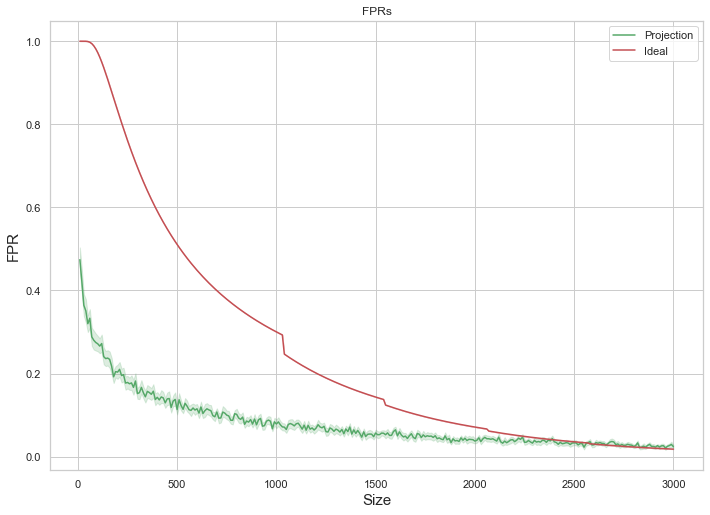

In [17]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [18]:
average_fprs = num_of_iterations*average_fprs
print(len(average_fprs))

15000


In [19]:
average_times = num_of_iterations*average_times
print(len(average_times))

15000


In [20]:
print(average_fprs)

[0.47415094339622643, 0.42150943396226415, 0.3643396226415095, 0.35094339622641507, 0.32, 0.3332075471698112, 0.28830188679245283, 0.28018867924528307, 0.2749056603773585, 0.2716981132075472, 0.26622641509433964, 0.27226415094339623, 0.24094339622641514, 0.23603773584905657, 0.23735849056603772, 0.23415094339622644, 0.2177358490566038, 0.19226415094339624, 0.20471698113207548, 0.2035849056603773, 0.21018867924528306, 0.19528301886792454, 0.19735849056603771, 0.17716981132075474, 0.17867924528301887, 0.17547169811320756, 0.17754716981132074, 0.16679245283018868, 0.1820754716981133, 0.15188679245283018, 0.15415094339622645, 0.16679245283018865, 0.15377358490566043, 0.14415094339622642, 0.15716981132075472, 0.1543396226415095, 0.15018867924528306, 0.15754716981132078, 0.13754716981132076, 0.14283018867924532, 0.13660377358490566, 0.1437735849056604, 0.1415094339622642, 0.129622641509434, 0.13905660377358497, 0.14000000000000004, 0.11849056603773586, 0.13377358490566035, 0.1379245283018869

In [21]:
saved_data = list(zip(size_values, y_ideal, fpr_values, average_fprs, times, average_times))
df = pd.DataFrame(saved_data,columns = ['Size of filter(bits)','Ideal FPR', 'Projection FPR for iteration', 'Average Projection FPR', 'Projection Filter Total Creation Time(sec)', 'Average Projection Filter Total Creation Time(sec)'])
df.head()

,Size of filter(bits),Ideal FPR,Projection FPR for iteration,Average Projection FPR,Projection Filter Total Creation Time(sec),Average Projection Filter Total Creation Time(sec)
0,10,1.000000,0.443396,0.474151,0.160984,0.159119
1,20,1.000000,0.462264,0.421509,0.149614,0.158166
2,30,0.999994,0.330189,0.364340,0.201763,0.154243
3,40,0.999881,0.386792,0.350943,0.166423,0.162226
4,50,0.999263,0.443396,0.320000,0.181681,0.161207


In [22]:
df.to_csv('/Users/aditijain/Desktop/NewFolderWithItems/SURA/BreastCancer_rerun_epochs_100.csv')